## Prepare data for transaction recovery training jobs

Install dependecies

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 6.2 MB/s eta 0:00:00a 0:00:01m
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 12.8 MB/s eta 0:00:0000:0100:01
  Created wheel for bokeh: filename=bokeh-2.0.1-py3-none-any.whl size=9080015 sha256=c481c69eadb55bc238f277f4562b37661ade02fa41e1667c9bf04a974ced834d
  Stored in directory: /home/sagemaker-user/.cache/pip/wheels/be/b4/d8/7ce778fd6e637bea03a561223a77ba6649aff8168e3c613754
Successfully built bokeh
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
  Attempting uninstall: bokeh
    Found existing installation: bokeh 3.6.2
    Uninstalling bokeh-3.6.2:
      Successfully uninstalled bokeh-3.6.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not install packages due t

In [15]:
# from sklearn.metrics import RocCurveDisplay, auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from time import gmtime, strftime

import numpy as np

import json 

import matplotlib.pyplot as plt 
import seaborn as sns


In [16]:
import pandas as pd

### Evaluate Original Data set
* Total features 12
* Display ranges of values and distibutions
* See how values for target column (churn) are distributed
* Plot outliers (balance)
* Create new feautures `engagement_score` and `failed_billing_count` based on existing features
* Drop sensitive data fields

In [17]:
df = pd.read_csv("data/bank_churn_data.csv")

In [5]:
pip install python-docx

Note: you may need to restart the kernel to use updated packages.


In [18]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [19]:
# print the total of observations and features
df.shape

(10000, 12)

In [93]:
df.columns

Index(['customer_id', 'credit_score', 'country', 'gender', 'age', 'tenure',
       'balance', 'products_number', 'credit_card', 'active_member',
       'estimated_salary', 'churn'],
      dtype='object')

In [94]:
# use `describe` function to output statistics
selected_cols = df.select_dtypes(include=["int64", "float64"])

# Step 2: Exclude the column `customer_id`
selected_cols = selected_cols.loc[:, selected_cols.columns != "customer_id"]

# Step 3: Compute descriptive statistics
description = selected_cols.describe()

print(description)

       credit_score           age        tenure        balance  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288   
std       96.653299     10.487806      2.892174   62397.405202   
min      350.000000     18.000000      0.000000       0.000000   
25%      584.000000     32.000000      3.000000       0.000000   
50%      652.000000     37.000000      5.000000   97198.540000   
75%      718.000000     44.000000      7.000000  127644.240000   
max      850.000000     92.000000     10.000000  250898.090000   

       products_number  credit_card  active_member  estimated_salary  \
count     10000.000000  10000.00000   10000.000000      10000.000000   
mean          1.530200      0.70550       0.515100     100090.239881   
std           0.581654      0.45584       0.499797      57510.492818   
min           1.000000      0.00000       0.000000         11.580000   
25%           1.000000      0.00000       0.0

In [20]:
# count the total number of churning customer and not churning 
x = df[df['churn'] == 1]['churn']
y = df[df['churn'] == 0]['churn']
print(f"Customer churn {len(x)}")
print(f"Customer not churn {len(y)}")

neg, pos = np.bincount(df['churn'])
total = neg + pos
print('Total: {}\nPositive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Customer churn 2037
Customer not churn 7963
Total: 10000
Positive: 2037 (20.37% of total)



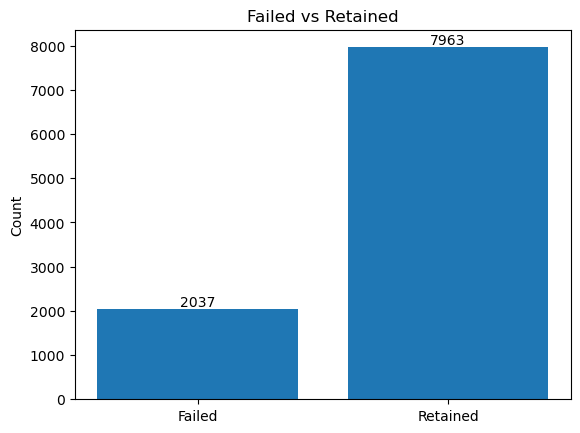

In [22]:
# plot the distribution of target variable (churn)
churn_count = len(x)

not_churn_count = len(y)

# Set up the plot
fig, ax = plt.subplots()

# Create the bar plot
bar_container = ax.bar(['Failed', 'Retained'], [churn_count, not_churn_count])

# label bars
ax.bar_label(bar_container)

# Add labels to the columns
ax.set_ylabel('Count')
ax.set_title('Failed vs Retained')
plt.show()

There are 2037 customers who churned and 7963 customers who didn’t churn.

In [97]:
#df.groupby("credit_card").agg(pl.count("churn").alias("churn_count"))
df.groupby("credit_card")["churn"].count().reset_index(name="churn_count")


,credit_card,churn_count
0,0,2945
1,1,7055


In [98]:
# compute `credit_score`, `balance`, `estimated_salary` grouped by churn
# df.groupby("churn").agg([pl.mean("credit_score"), pl.mean("balance"), pl.mean("estimated_salary"),
#                          pl.mean("age")])
result = df.groupby("churn").agg({
    "credit_score": "mean",
    "balance": "mean",
    "estimated_salary": "mean",
    "age": "mean"
}).reset_index()
print(result)


   churn  credit_score       balance  estimated_salary        age
0      0    651.853196  72745.296779      99738.391772  37.408389
1      1    645.351497  91108.539337     101465.677531  44.837997


In [149]:
# check if there is any null value
null_counts = df.isnull().sum()
print(null_counts)

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64


In [100]:
print(f"Minimum Credit Score {df['credit_score'].min()}")
print(f"Maximum Credit Score {df['credit_score'].max()}")

Minimum Credit Score 350
Maximum Credit Score 850


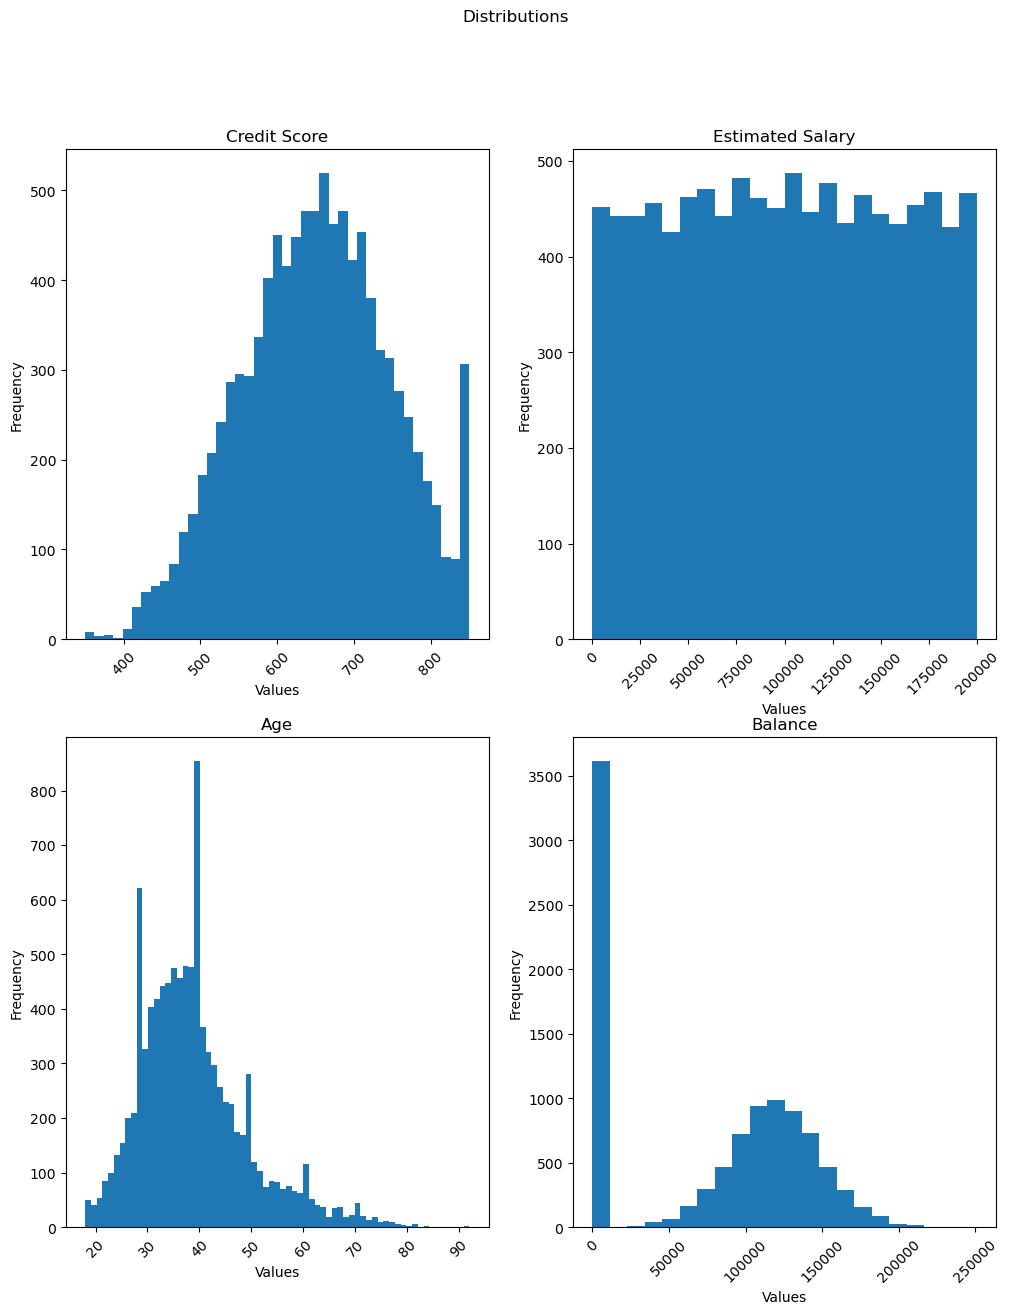

In [30]:
# plot the distribution of `credit_score`, `age`, `estimated_salary` and `balance`
fig, axs = plt.subplots(2, 2, figsize=(12,14))

axs[0,0].hist(df["credit_score"], bins='auto')
axs[0,0].set_title('Credit Score')

axs[1,0].hist(df["age"], bins='auto')
axs[1,0].set_title('Age')

axs[0,1].hist(df["estimated_salary"], bins='auto')
axs[0,1].set_title('Estimated Salary')

axs[1,1].hist(df["balance"], bins='auto')
axs[1,1].set_title('Balance')

fig.suptitle('Distributions')
axs[0,0].set_xlabel('Values')
axs[0,0].set_ylabel('Frequency')
axs[1,0].set_xlabel('Values')
axs[1,0].set_ylabel('Frequency')
axs[0,1].set_xlabel('Values')
axs[0,1].set_ylabel('Frequency')
axs[1,1].set_xlabel('Values')
axs[1,1].set_ylabel('Frequency')

# Rotate x-axis labels on all subplots
for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=45)

# Show plot
plt.show()

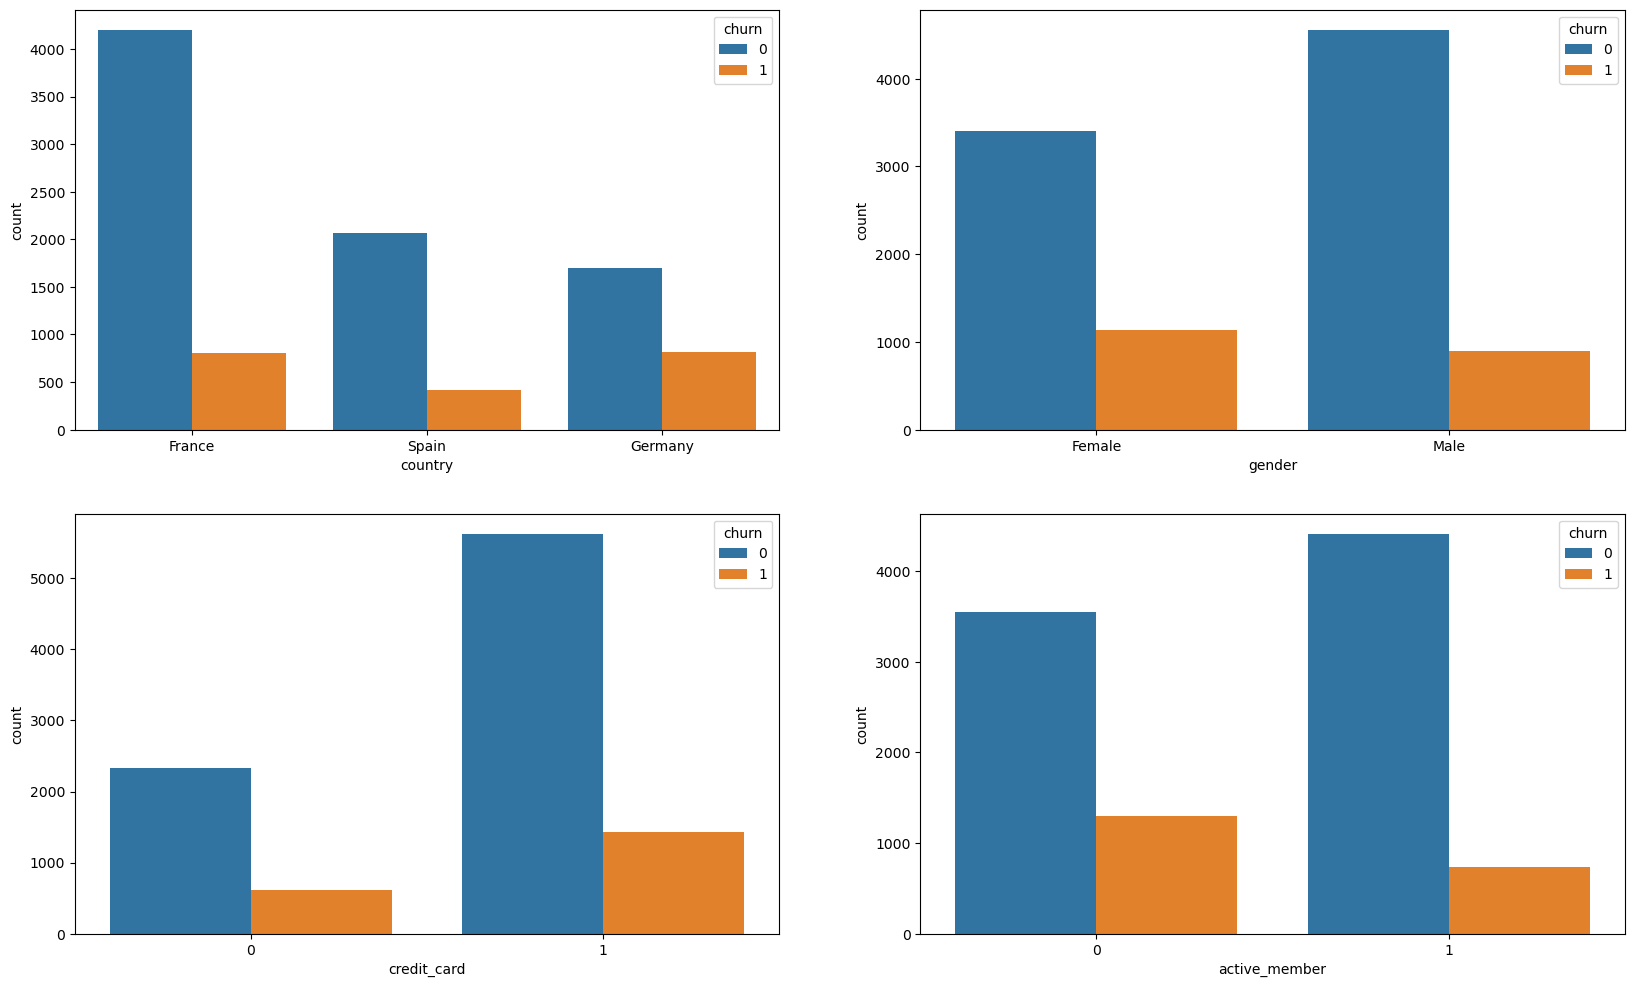

In [26]:
# Review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='country', hue = 'churn',data = df, ax=axarr[0][0])
sns.countplot(x='gender', hue = 'churn',data = df, ax=axarr[0][1])
sns.countplot(x='credit_card', hue = 'churn',data = df, ax=axarr[1][0])
sns.countplot(x='active_member', hue = 'churn',data = df, ax=axarr[1][1])
plt.savefig(f"transaction_status_by_categories.png")

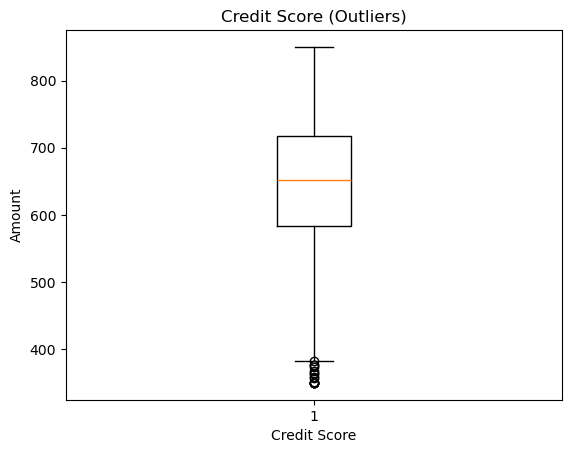

In [31]:
# create a box plot of the `credit score` column
plt.boxplot(df["credit_score"], )

# add labels and a title
plt.xlabel("Credit Score")
plt.ylabel('Amount')
plt.title("Credit Score (Outliers)")

# show the plot
plt.show()

The box plot shows the inter range value of Credit Score column, the orange line shows the median value.As we can see there are some outliers (circles in the figure) which we can remove later and test the performance of our model without it.

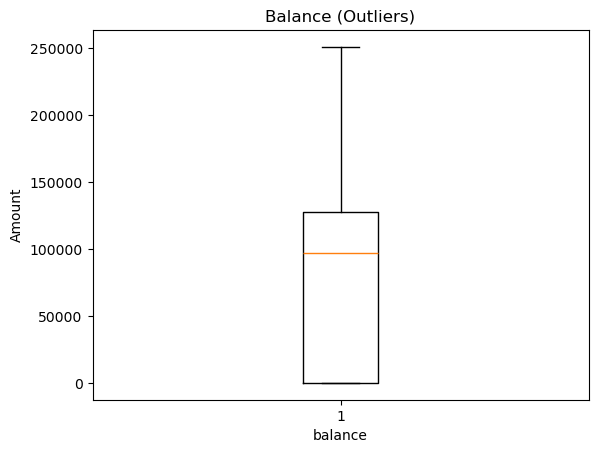

In [41]:
# create a box plot of the "estimated_salary" column
plt.boxplot(df["balance"], )

# add labels and a title
plt.xlabel("balance")
plt.ylabel('Amount')
plt.title("Balance (Outliers)")

# show the plot
plt.show()

In [150]:
# let us look at balamce as we want re-purpose it into transaction amount
x = df[df['balance'] > 0]['balance']
y = df[df['balance'] == 0]['balance']
print(f"Customer non-zero balance  {len(x)}")
print(f"Customer zero balance {len(y)}")
df['balance_condition'] = df['balance'].apply(lambda x: 'balance > 0' if x > 0 else 'balance = 0')

# Group by both the balance condition and churn, and count the occurrences
result = df.groupby(['balance_condition', 'churn']).size().reset_index(name='count')

# Display the result
print(result)



Customer non-zero balance  6383
Customer zero balance 3617
  balance_condition  churn  count
0       balance = 0      0   3117
1       balance = 0      1    500
2       balance > 0      0   4846
3       balance > 0      1   1537


 It is hard to explan, why churn is higher for customers with higher balance, 
 however for our model  it does actuall work as we expect higher amount transactions to be failing more  often

In [151]:
# Generate engagement score
import numpy as np
df['amount_due'] = (df['balance']/1000).round(2) + 1
df['engagement_score'] = (
    0.4 * df['tenure'] / df['tenure'].max() +  # Scale tenure
    0.4 * df['products_number'] / df['products_number'].max() +  # Scale products_number
    0.2 * df['active_member']  # Active member contributes directly
) * 100  # Scale to a range of 0-100

# Define tiers based on salary percentiles
salary_bins = np.percentile(df['estimated_salary'], [33, 66])
df['subscription_tier'] = pd.cut(
    df['estimated_salary'],
    bins=[-np.inf, salary_bins[0], salary_bins[1], np.inf],
    labels=['Basic', 'Standard', 'Premium']
)


# Normalize credit_score to range [0, 1]
normalized_credit_score = (df['credit_score'] - df['credit_score'].min()) / (df['credit_score'].max() - df['credit_score'].min())

# Simulate billing_failure_count
df['billing_failure_count'] = np.random.poisson(
    lam=3 * (1 - normalized_credit_score) + 0.5 * (df['amount_due'] > df['amount_due'].median()),
    size=len(df)
)




df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,balance_condition,amount_due,engagement_score,subscription_tier,billing_failure_count
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1,balance = 0,1.00,38.0,Standard,2
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,balance > 0,84.81,34.0,Standard,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,balance > 0,160.66,62.0,Standard,2
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0,balance = 0,1.00,24.0,Standard,1
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,balance > 0,126.51,38.0,Standard,0


## Feature Engineering
* Exclude unwanted columns
* Remove duplicates
* Finally, split cleaned file into train set (60%), validation set (20%) and test set (20%). These thress sets will be used in training / validation / evaluation steps for all models


In [152]:
df = df.drop(columns=['balance', 'credit_score', 'balance_condition', 'estimated_salary', 'customer_id'])

In [153]:
from sklearn.preprocessing import OneHotEncoder

df = df.rename(columns={'amount_due': 'amount', 'churn': 'failed'})
columns = list(df.columns) 
columns.append(columns.pop(columns.index('failed'))) 
df = df[columns]
print (df.head())




  country  gender  age  tenure  products_number  credit_card  active_member  \
0  France  Female   42       2                1            1              1   
1   Spain  Female   41       1                1            0              1   
2  France  Female   42       8                3            1              0   
3  France  Female   39       1                2            0              0   
4   Spain  Female   43       2                1            1              1   

   amount  engagement_score subscription_tier  billing_failure_count  failed  
0    1.00              38.0          Standard                      2       1  
1   84.81              34.0          Standard                      0       0  
2  160.66              62.0          Standard                      2       1  
3    1.00              24.0          Standard                      1       0  
4  126.51              38.0          Standard                      0       0  


In [32]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [154]:
# remove duplicates that have different target values 
target_column = 'failed'
duplicates = df.duplicated(subset=df.columns.difference([target_column]), keep=False)
duplicate_rows = df[duplicates]
grouped = duplicate_rows.groupby(list(df.columns.difference([target_column])))
indices_to_remove = []

for key, group in grouped:
    if group[target_column].nunique() > 1:
        indices_to_remove.extend(group.index)

cleaned_df = df.drop(indices_to_remove)

cleaned_df.to_csv('data/cleaned_file.csv', index=False)
print("Cleaned data saved successfully!")


/tmp/ipykernel_30105/1858802406.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = duplicate_rows.groupby(list(df.columns.difference([target_column])))


Cleaned data saved successfully!


In [34]:
cleaned_df = pd.read_csv("data/cleaned_file.csv")
cleaned_df.head()

,country,gender,age,tenure,products_number,credit_card,active_member,amount,engagement_score,subscription_tier,billing_failure_count,failed
0,France,Female,42,2,1,1,1,1.00,38.0,Standard,2,1
1,Spain,Female,41,1,1,0,1,84.81,34.0,Standard,0,0
2,France,Female,42,8,3,1,0,160.66,62.0,Standard,2,1
3,France,Female,39,1,2,0,0,1.00,24.0,Standard,1,0
4,Spain,Female,43,2,1,1,1,126.51,38.0,Standard,0,0


In [157]:
# Split file in to train / validate / test. We want to use same files to train different models
from sklearn.model_selection import train_test_split
import os


train, temp = train_test_split(cleaned_df, test_size=0.4, random_state=42)  # 60% train
validate, test = train_test_split(temp, test_size=0.5, random_state=42)  # 20% validate, 20% test

original_file_path = "data/cleaned_file.csv" 
directory = os.path.dirname(original_file_path)
train.to_csv(os.path.join(directory, 'train.csv'), index=False)
validate.to_csv(os.path.join(directory, 'validate.csv'), index=False)
test.to_csv(os.path.join(directory, 'test.csv'), index=False)


# Print a confirmation message
print(f"Data saved to {directory}")

Data saved to data


In [1]:
import os

def count_lines_in_file(file_path):
    with open(file_path, 'r') as file:
        return sum(1 for line in file)

directory = 'data'
files = ['train.csv', 'validate.csv', 'test.csv', 'cleaned_file.csv']

# Count lines for each file
for file_name in files:
    file_path = os.path.join(directory, file_name)
    line_count = count_lines_in_file(file_path)
    print(f"The file {file_name} has {line_count} lines.")


The file train.csv has 5990 lines.
The file validate.csv has 1998 lines.
The file test.csv has 1998 lines.
The file cleaned_file.csv has 9984 lines.
